### Ablauf der Berechnung und Darstellung

1. Für vorgegebene Erkrankungsraten (15 %, 30 %, 50 %, 70 %) werden die zentralen Modellparameter
   (Konsultationsanteil, Hospitalisierungsrate, Letalität) als Dreiecksverteilungen simuliert
   (Monte-Carlo-Simulation).

2. Die Simulationsergebnisse werden gespeichert und als vergleichende Boxplots dargestellt;
   der Punkt markiert jeweils den deterministischen Referenzwert gemäß Pandemieplan.

3. Die Auswertung erfolgt in zwei Varianten:
   - normiert auf 100.000 Einwohner (vergleichende Darstellung),
   - bezogen auf die Bevölkerung des Rhein-Sieg-Kreises
     (Stichtag: 31.12.2024).

> **Hier:** normiert auf 100.000 Einwohner (vergleichende Darstellung)

---

### ▶️ Ausführen des Programms

- Klicken Sie in die Code-Zelle.
- Drücken Sie `Shift + Enter`, um die Berechnung zu starten.  
  Alternativ können Sie auch auf **▶ Run** oben in der Werkzeugleiste klicken. 
- Über **Run → Run all cells** werden alle Zellen auf einmal ausgeführt.

---



In [1]:
import numpy as np
import pandas as pd

# =============================================================
# Eingaben
#==============================================================

pop = 100_000  # Angaben je ... Einwohner
n = 200_000

attack_rates = [0.15, 0.30, 0.50,0.70]

tri = dict(
    consult_frac=(0.45, 0.50, 0.55),
    hosp_per_consult=(0.024, 0.027, 0.030),
    death_per_consult=(0.004, 0.007, 0.010),
)

rng = np.random.default_rng(42)

#===========================================================
# Berechnungen - Monte-Carlo-Simulation (Dreiecksverteilung)
# ==========================================================

records = []

for ar in attack_rates:
    cf = rng.triangular(*tri["consult_frac"], size=n)
    hp = rng.triangular(*tri["hosp_per_consult"], size=n)
    dp = rng.triangular(*tri["death_per_consult"], size=n)

    ill = pop * ar
    consult = ill * cf
    hosp = consult * hp
    deaths = consult * dp

    df_ar = pd.DataFrame({
        "attack_rate": ar,
        "ill_total": ill,
        "consult_total": consult,
        "hosp_total": hosp,
        "deaths_total": deaths,
    })

    records.append(df_ar)

# DAS ist das gesuchte Objekt
sim = pd.concat(records, ignore_index=True)


In [2]:
# ======== Zusatzprogramme (Plot, Berechnungen ========

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from typing import Sequence, Mapping, Optional

def title_over_axes(
    fig: plt.Figure,
    ax: plt.Axes,
    *,
    title: str,
    subtitles: Sequence[str] = (),
    title_size: int = 12,
    subtitle_size: int = 10,
    pad_title: float = 0.0150,
    pad_between: float = 0.012,
):
    """Titel + (mehrere) Subtitel zentriert über der Achsenbox (TikZ-analog)."""
    bbox = ax.get_position()
    x = bbox.x0 + bbox.width / 2
    y = bbox.y1 + pad_title

    fig.text(x, y, title, ha="center", va="bottom", fontsize=title_size)

    for i, sub in enumerate(subtitles, start=1):
        fig.text(
            x,
            y - i * pad_between,
            sub,
            ha="center",
            va="bottom",
            fontsize=subtitle_size,
        )

def boxplot_compare_attack_rates_bw_horizontal(
    df: pd.DataFrame,
    *,
    attack_rates: Sequence[float],
    value_col: str,
    xlabel: str = "Personen",
    title: str,
    subtitles: Sequence[str] = (),
    ref_values: Optional[Mapping[float, float]] = None,  # attack_rate -> Referenzwert
    show: bool = True,
    outpath: Path | None = None,
    # Stil/Geometrie
    fig_size: tuple[float, float] = (7, 3.2),
    box_width: float = 0.50,
    y_spacing: float = 1.25,
    top_rect: float = 0.84,
):
    """
    Vergleichende Boxplot-Grafik (schwarz/weiß), horizontal ausgerichtet.
    Optional mit Referenzpunkt ● pro Erkrankungsrate (Pandemieplan).
    """

    # Daten je Erkrankungsrate
    data = [
        df.loc[df["attack_rate"] == ar, value_col].dropna()
        for ar in attack_rates
    ]

    labels = [f"{int(ar*100)} %" for ar in attack_rates]

    # Exakte y-Positionen (für Box + ● + Labels)
    positions = [1 + i * y_spacing for i in range(len(attack_rates))]

    fig, ax = plt.subplots(figsize=fig_size)

    ax.boxplot(
        data,
        positions=positions,
        vert=False,
        widths=box_width,
        showfliers=False,
        boxprops=dict(linewidth=1.1, color="black"),
        medianprops=dict(linewidth=1.5, color="black"),
        whiskerprops=dict(linewidth=1.1, color="black"),
        capprops=dict(linewidth=1.1, color="black"),
    )

    # Referenzpunkte ● exakt auf der jeweiligen Zeile
    if ref_values is not None:
        for y, ar in zip(positions, attack_rates):
            if ar in ref_values and ref_values[ar] is not None:
                ax.scatter(
                    ref_values[ar],
                    y,
                    marker="o",
                    s=14,
                    color="black",
                    zorder=4,
                )

    # y-Achse: Kategorien
    ax.set_yticks(positions)
    ax.set_yticklabels(labels, fontsize=10)

    # x-Achse: nur Einheit, nicht nochmal "Hospitalisierungen ..."
    ax.set_xlabel(xlabel, fontsize=11)
    ax.tick_params(axis="x", labelsize=10)

    ax.grid(False)

    # Layout fixieren (Platz oben für Titel/Subtitel)
    fig.tight_layout(rect=[0.04, 0.06, 0.98, top_rect])

    # Titel/Subtitel figure-basiert über Achse zentriert
    title_over_axes(
        fig,
        ax,
        title=title,
        subtitles=subtitles,
        title_size=12,
        subtitle_size=10,
        pad_title=0.210,
        pad_between=0.08,
    )

    if outpath is not None:
        outpath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return None #fig

# ====== deterministische Referenzwerte (Punktwerte) aus den Zentralwerten =======
base = dict(
    consult_frac=tri["consult_frac"][1],          # 0.50
    hosp_per_consult=tri["hosp_per_consult"][1],  # 0.027
    death_per_consult=tri["death_per_consult"][1] # 0.007
)

ref_hosp = {}
ref_deaths = {}

for ar in attack_rates:
    ill = pop * ar
    consult = ill * base["consult_frac"]
    ref_hosp[ar] = consult * base["hosp_per_consult"]
    ref_deaths[ar] = consult * base["death_per_consult"]

ref_hosp, ref_deaths

#=======================

df_ref = pd.DataFrame({
    "attack_rate": attack_rates,
})
df_ref["ill_total"] = pop * df_ref["attack_rate"]
df_ref["consult_total"] = df_ref["ill_total"] * base["consult_frac"]
df_ref["hosp_total"] = df_ref["consult_total"] * base["hosp_per_consult"]
df_ref["deaths_total"] = df_ref["consult_total"] * base["death_per_consult"]

ref_hosp = dict(zip(df_ref["attack_rate"], df_ref["hosp_total"]))
ref_deaths = dict(zip(df_ref["attack_rate"], df_ref["deaths_total"]))

def subtitle_population(pop: int) -> str:
    return f"Angaben je {pop:,.0f} Einwohner".replace(",", ".")

def subtitle_tri(name: str, tri: tuple[float, float, float], digits: int = 3) -> str:
    a, m, b = tri
    fmt = f"{{:.{digits}f}}"
    return (
        f"{name} – Annahme (min / wahrscheinlich / max): "
        f"{fmt.format(a)} / {fmt.format(m)} / {fmt.format(b)}"
    ).replace(".", ",")

subtitles_hosp = [
    subtitle_population(pop),
    subtitle_tri("Hospitalisierungsrate pro Konsultation", tri["hosp_per_consult"]),
]

subtitles_deaths = [
    subtitle_population(pop),
    subtitle_tri("Todesrate pro Konsultation", tri["death_per_consult"]),
]

df_ref

,attack_rate,ill_total,consult_total,hosp_total,deaths_total
0,0.15,15000.0,7500.0,202.5,52.5
1,0.30,30000.0,15000.0,405.0,105.0
2,0.50,50000.0,25000.0,675.0,175.0
3,0.70,70000.0,35000.0,945.0,245.0


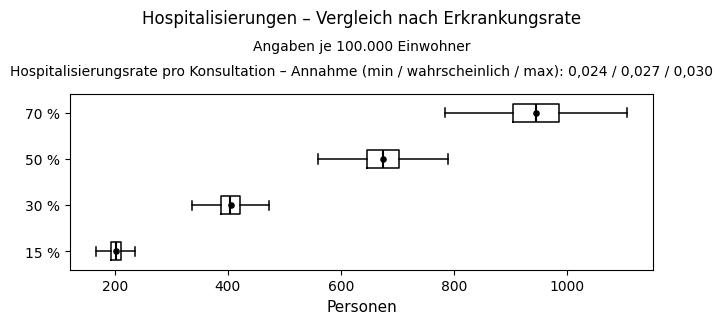

In [3]:
boxplot_compare_attack_rates_bw_horizontal(
    df=sim,
    attack_rates=attack_rates,
    value_col="hosp_total",
    xlabel="Personen",
    title="Hospitalisierungen – Vergleich nach Erkrankungsrate",
    subtitles=subtitles_hosp,
    ref_values=ref_hosp,
    show=True,
    outpath=Path("outputs/figures/Boxplots/boxplot_hosp_compare_100k_refdot.pdf"),
)

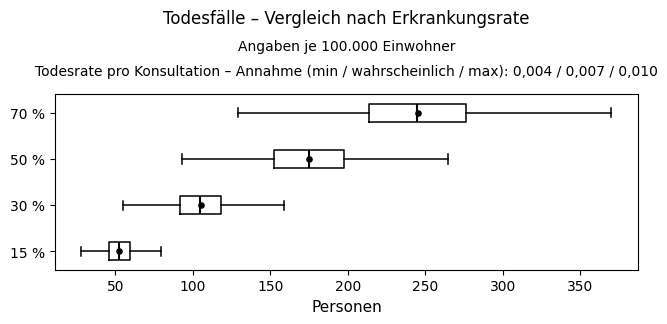

In [4]:
boxplot_compare_attack_rates_bw_horizontal(
    df=sim,
    attack_rates=attack_rates,
    value_col="deaths_total",
    xlabel="Personen",
    title="Todesfälle – Vergleich nach Erkrankungsrate",
    subtitles=subtitles_deaths,
    ref_values=ref_deaths,
    show=True,
    outpath=Path("outputs/figures/Boxplots/boxplot_deaths_compare_100k_refdot.pdf"),
)

>**Legende:** Die Boxplots zeigen die Verteilung der Ergebnisse aus einer Monte-Carlo-Simulation unter den dokumentierten Annahmen; der Punkt markiert jeweils den deterministischen Referenzwert gemäß Pandemieplan.